In [1]:
import numpy as np
import xray
import dask.array as daskarray
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (4096 ,4096 ))
resource.getrlimit(resource.RLIMIT_NOFILE)


(4096, 4096)

In [3]:
import xgcm

In [4]:
iters = range(2073840, 2384880, 480)
ddir = '/data/scratch/rpa/channel_moc/GCM/run'
ds = xgcm.open_mdsdataset(ddir, iters, deltaT=900)
ds

xgcm/mdsxray.py:201: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
xgcm/mdsxray.py:201: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xray.Dataset>
Dimensions:  (X: 200, Xp1: 200, Y: 400, Yp1: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 648)
Coordinates:
  * Xp1      (Xp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Yp1      (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Y        (Y) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * X        (X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * time     (time) int64 1866456000 1866888000 1867320000 1867752000 ...
Data variables:
    YC       (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    YG       (Yp1, Xp1) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    

In [5]:
def pow_spec_2d(x, axis=[-1,-2]):
    # x and time
    f = np.fft.fftn(x, axes=axis)
    return np.real(f * f.conj())

# operate on a dataarray
def xray_isotropic_power_spectrum(da, kiso=None, axis=('Y','X')):
    axis_num = [da.get_axis_num(a) for a in axis]
    # see if there are other coords to leave alone
    other_axis = set(da.dims).difference(axis)
    if other_axis:
        other_axis_num = [da.get_axis_num for a in other_axis]
    
    # calcualte wavenumbers from axes
    N = [da.shape[n] for n in axis_num]
    delta_x = [np.diff(da[a])[0] for a in axis]
    k = [ np.fft.fftfreq(Nx, dx) for (Nx, dx) in zip(N, delta_x)]
    kk = np.array(np.meshgrid(k[1], k[0]))
    k2 = (kk**2).sum(axis=0)
    
    # set up wavenumber range
    if kiso is None:
        # no isotropic wavenumber grid specified
        kidx = np.argmin( np.array([l.max() for l in k]) )
        kiso = k[kidx][:N[kidx]/2]
    Niso = len(kiso)
    bins = np.digitize(k2.ravel(), kiso**2)
    
    # do fft
    #def iso_ps(q):
    f = np.fft.fftn(da.values, axes=axis_num)
    # sum isotropically
    fiso = np.bincount(bins,
                       weights=np.real(f*f.conj()).ravel(),
                       minlength=Niso)[:Niso]
    # replace zeros with nans
    fiso[fiso==0.] = np.nan
    # normalize properly
    #count = np.bincount(bins, minlength=Niso)[:Niso]
    #fiso *= (kiso / count)
    # (didn't work like I hoped)
    return xray.DataArray(fiso, coords={'k_iso': kiso})

def ts_iso_power_spec(sst):
    kiso = np.linspace(0,(5000.)**-1 / np.sqrt(2), 100)
    xvars = set(['X', 'Xp1'])
    yvars = set(['Y', 'Yp1'])
    xvar = xvars.intersection(sst.dims).pop()
    yvar = yvars.intersection(sst.dims).pop()
    ssta = sst - sst.mean(dim=xvar)
    hwin = np.hanning(ds[yvar].shape[0])
    window = xray.DataArray(daskarray.from_array(hwin, hwin.shape), coords={yvar: ds[yvar]})
    sst_win = ssta * window
    return sst_win.groupby('time').apply( lambda q: xray_isotropic_power_spectrum(q, kiso=kiso, axis=(yvar,xvar)) )

In [6]:
%time t_ps = ts_iso_power_spec(ds['THETA'].isel(Z=0))
%time u_ps = ts_iso_power_spec(ds['UVEL'].isel(Z=0))
%time v_ps = ts_iso_power_spec(ds['VVEL'].isel(Z=0))
%time w_ps = ts_iso_power_spec(ds['WVEL'].isel(Zl=5))

CPU times: user 12.1 s, sys: 3.21 s, total: 15.3 s
Wall time: 30 s
CPU times: user 11.3 s, sys: 3.33 s, total: 14.7 s
Wall time: 33.4 s
CPU times: user 11.3 s, sys: 3.17 s, total: 14.4 s
Wall time: 33.6 s
CPU times: user 11.2 s, sys: 3.12 s, total: 14.3 s
Wall time: 31.2 s


In [37]:
eke_ps = 0.5 * (u_ps + v_ps)

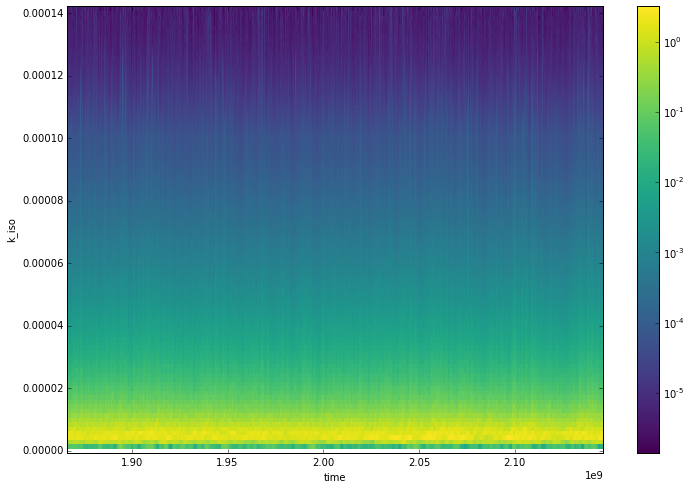

In [38]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(12,8))
pc = xray.plot.pcolormesh(eke_ps.T, norm=LogNorm())


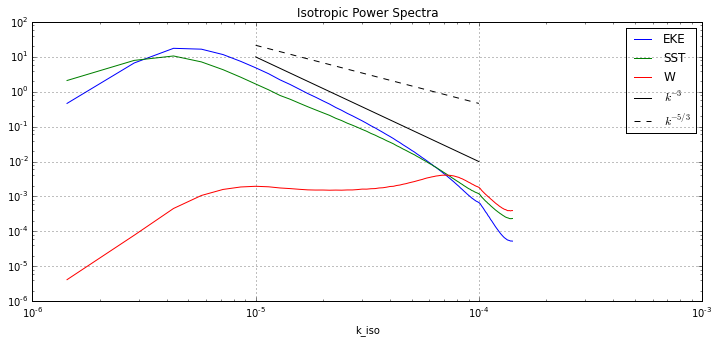

In [45]:
plt.figure(figsize=(12,5))

ax = plt.subplot(111)
xray.plot.plot(10*eke_ps.mean(dim='time'))
xray.plot.plot(t_ps.mean(dim='time'))
xray.plot.plot(1e5*w_ps.mean(dim='time'))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e4,1e9])

x0 = np.array([1e-5, 1e-4])
plt.plot(x0, 1e-14*x0**(-3), 'k-')
plt.plot(x0, 1e-7*x0**(-5./3), 'k--')
plt.legend(['EKE', 'SST', 'W', r'$k^{-3}$', r'$k^{-5/3}$'])
plt.grid()
plt.title('Isotropic Power Spectra')

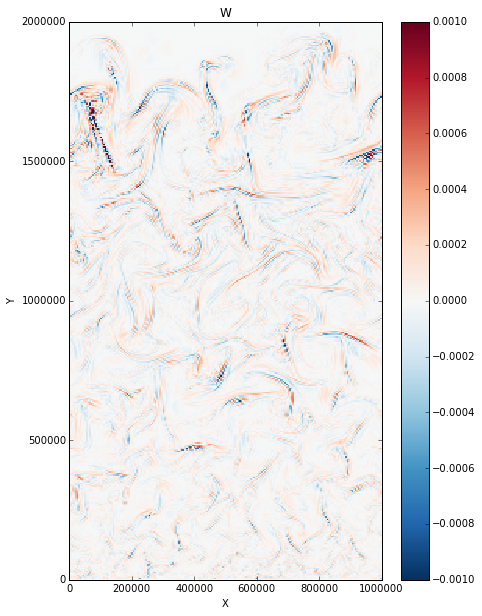

In [23]:
plt.figure(figsize=(7,10))
pc = xray.plot.pcolormesh(ds['WVEL'].isel(time=0,Zl=5))
pc.set_clim([-1e-3,1e-3])
plt.title('W')

In [58]:
Ny,Nx = (32,16)
a = np.random.rand(Nx)
afft = np.fft.fftn(a)
b = np.random.rand(Ny,Nx)
bfft = np.random.rand()
print (a**2).mean()
print np.real(a*a.conj()).sum()
print (b**2).mean()
print np.real(b*b.conj()).sum()


0.274782525764
4.39652041222
0.316890404743
162.247887228
